In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import base64
from glob import glob
import cv2

In [2]:
for dirname, _, filenames in os.walk('./eliva-25-image-restoration/data25'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./eliva-25-image-restoration/data25\img1.jpg
./eliva-25-image-restoration/data25\img10.jpg
./eliva-25-image-restoration/data25\img11.jpg
./eliva-25-image-restoration/data25\img12.jpg
./eliva-25-image-restoration/data25\img13.jpg
./eliva-25-image-restoration/data25\img14.jpg
./eliva-25-image-restoration/data25\img15.jpg
./eliva-25-image-restoration/data25\img2.jpg
./eliva-25-image-restoration/data25\img3.jpg
./eliva-25-image-restoration/data25\img4.jpg
./eliva-25-image-restoration/data25\img5.jpg
./eliva-25-image-restoration/data25\img6.jpg
./eliva-25-image-restoration/data25\img7.jpg
./eliva-25-image-restoration/data25\img8.jpg
./eliva-25-image-restoration/data25\img9.jpg
./eliva-25-image-restoration/data25\test.csv
./eliva-25-image-restoration/data25\train.csv


PSF shape: (512, 512, 3)
Tipo immagine: uint8
Valori min/max: 0 255


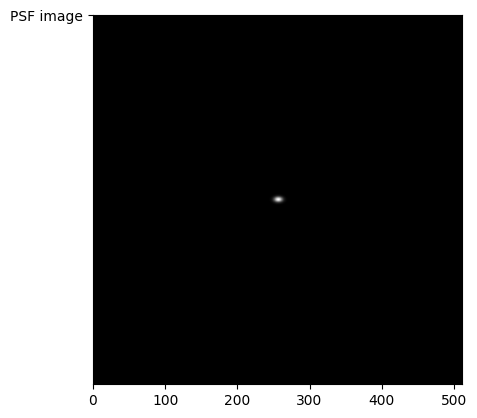

In [3]:
psf = cv2.imread('./eliva-25-image-restoration/PSF_image.png')

print(f"PSF shape: {psf.shape}")
print("Tipo immagine:", psf.dtype)
print("Valori min/max:", psf.min(), psf.max())

plt.figure()
plt.imshow(psf)
plt.plot('PSF image')

In [169]:
def compute_alpha_from_contrast(img, min_alpha=0.5, max_alpha=1.0):
    contrast = img.std()
    contrast_norm = np.clip((contrast - 10) / 50, 0, 1)
    return min_alpha + (max_alpha - min_alpha) * (1 - contrast_norm)

In [ ]:
def restore(img, psf, eps=1e-3):
    # Verifica formato corretto
    assert img.ndim == 3 and img.shape[2] == 3, "Immagine non RGB"
    assert psf.ndim == 3 and psf.shape[2] == 3, "PSF non RGB"

    # Prepara output
    channels_restored = []
    alpha = compute_alpha_from_contrast(img) # 0 = solo originale, 1 = solo restaurata

    # Per ogni canale (B, G, R)
    for c in range(3):
        img_c = img[:, :, c].astype(np.float32) / 255.0
        psf_c = psf[:, :, c].astype(np.float32)
        psf_c /= np.sum(psf_c) + 1e-8  # normalizza per evitare divisione per zero

        # Fourier transform
        G = np.fft.fft2(img_c)
        psf_c_shifted = np.fft.ifftshift(psf_c)

        """plt.figure()
        plt.imshow(psf_c_shifted)
        plt.plot('PSF image shifted')"""

        H = np.fft.fft2(psf_c_shifted)

        # Inverse filter con stabilizzazione
        # Inverse filtering (evitiamo divisione per zero)
        H_conj = np.conj(H)
        H_abs2 = np.abs(H)**2
        F_hat = G * H_conj / (H_abs2 + eps)

        img_restored = np.fft.ifft2(F_hat).real

        # Clip e conversione
        img_restored = np.clip(img_restored, 0, 1)
        img_restored = (img_restored * 255).astype(np.uint8)

        channels_restored.append(img_restored)

    # Ricombina i 3 canali (cv2 usa BGR)
    restored_color = cv2.merge(channels_restored)

    img_final = cv2.addWeighted(restored_color, alpha, img, 1 - alpha, 0)

    return img_final


test img shape: (512, 512, 3)
Tipo immagine: uint8
Valori min/max: 0 249
Alpha è: 0.5280792299335132


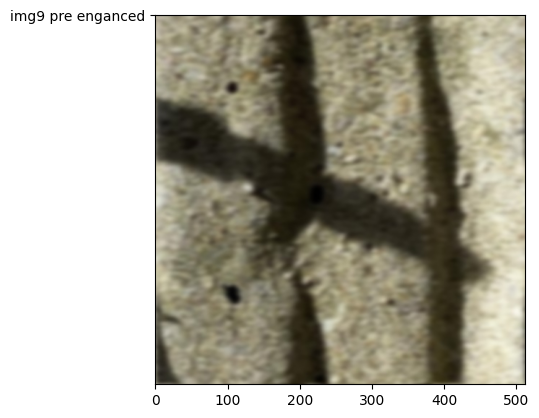

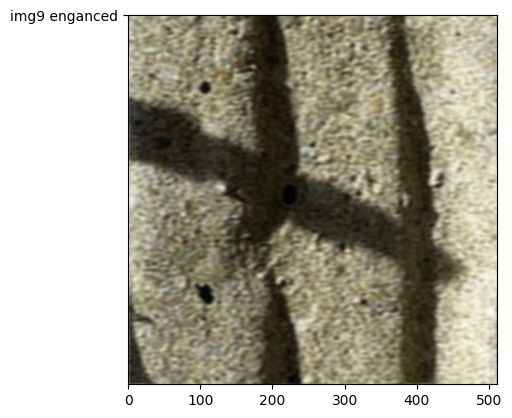

In [ ]:
test_image = cv2.imread('./eliva-25-image-restoration/data25/img1.jpg')
# OpenCV works follows BGR color convention internally, not RBG. So I'll swap the B and R channels
test_image = test_image[:, :, ::-1]

print(f"test img shape: {test_image.shape}")
print("Tipo immagine:", test_image.dtype)
print("Valori min/max:", test_image.min(), test_image.max())

plt.figure()
plt.imshow(test_image)
plt.plot('img9 pre-enhancement')

enhanced = restore(test_image, psf)

plt.figure()
plt.imshow(enhanced)
plt.plot('img9 enhanced')

In [159]:
#encode an image to embed it in the .csv file
def encode_img(img):
    # Encode image into base64 text
    retval, buffer = cv2.imencode('.jpg', img)
    return base64.b64encode(buffer).decode('utf-8')

In [ ]:
solution = {'id': [], 'data': []}

for path in glob('./eliva-25-image-restoration/data25/*.jpg'):
    img = cv2.imread(path)
    enhanced = restore(img, psf)

    # encoder_img to solution.csv
    solution['id'].append(os.path.basename(path))
    solution['data'].append(encode_img(enhanced))

    cv2.imwrite(os.path.basename(path), enhanced)

df = pd.DataFrame(solution)
df.to_csv('submission.csv', index=False)

Alpha è: 0.5280792299335132
Alpha è: 0.5
Alpha è: 0.7367676191601766
Alpha è: 0.5906214499196607
Alpha è: 0.6287371362326586
Alpha è: 0.8572144102914157
Alpha è: 0.7390367430528602
Alpha è: 0.5
Alpha è: 0.8425440156053928
Alpha è: 0.7847406765571279
Alpha è: 0.6812408863951247
Alpha è: 0.6166311677025229
Alpha è: 0.5
Alpha è: 0.6939733136373094
Alpha è: 0.7729951686371986
